<a href="https://colab.research.google.com/github/anshuman2007/Garud-Lab-Research-Project/blob/main/Lab_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [22]:
#hide - Loading libraries
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *
import pandas as pd
import numpy as np
import nltk
from fastai.vision import *
from fastai.metrics import error_rate # 1 - accuracy
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
##from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"

# Creating a dataframe from CSV file
df = pd.read_csv("/content/gdrive/My Drive/fastai-v3/full.csv") 

# Removing stopwords
# function to apply stopwords to the Tweets cleaned tokenized column

def stopwords_clean(text):
    stop_words = set(stopwords.words('english'))
    no_stopword_text = [w for w in str(text).split() if not w in stop_words]
    return " ".join(no_stopword_text)

df['Text'] = df['Text'].apply(lambda x: stopwords_clean(x))

# SPLIT INTO TRAIN TEST AND VALID

train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.4*len(df)), int(.7*len(df))])
              
# combine train and test to create learner object
trn = pd.concat([train,test])

In [24]:
trn.shape[0]

8377

In [25]:
### Fine-Tuning Language Model
# Step 1: Creating a DataLoaders object
dls_lm = TextDataLoaders.from_df(trn, valid_pct = 0.2, text_col='Text', is_lm = True)
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos 1 . xxmaj biomacromolecules . 2018 xxmaj sep xxunk - xxunk . doi : 10.1021 / xxunk . xxmaj epub 2018 xxmaj aug 22 . xxmaj cargo xxmaj retention inside xxup p22 virus - like xxmaj particles . mccoy xxup k(1 ) , xxmaj xxunk xxup e(1 ) , xxmaj luque xxup d(2)(3 ) , xxmaj lee xxup b(4 ) , xxmaj edwards xxup e(1 ) , xxmaj xxunk xxup jr(2","1 . xxmaj biomacromolecules . 2018 xxmaj sep xxunk - xxunk . doi : 10.1021 / xxunk . xxmaj epub 2018 xxmaj aug 22 . xxmaj cargo xxmaj retention inside xxup p22 virus - like xxmaj particles . mccoy xxup k(1 ) , xxmaj xxunk xxup e(1 ) , xxmaj luque xxup d(2)(3 ) , xxmaj lee xxup b(4 ) , xxmaj edwards xxup e(1 ) , xxmaj xxunk xxup jr(2 )"
1,", colocalization viral proteins , disruption xxup cd1 recycling machinery . xxmaj finally , even low titers xxup hsv interfered capacity infected xxup dc stimulate release important cytokines cd1d - restricted xxup nkt cells . xxmaj thus , demonstrate existence xxup cd1 pathway allowing human xxup dc react viral infection , well blockage human herpesvirus . xxup doi : 10.4049 / xxunk xxup pmid : xxunk [ indexed xxup medline ] xxbos","colocalization viral proteins , disruption xxup cd1 recycling machinery . xxmaj finally , even low titers xxup hsv interfered capacity infected xxup dc stimulate release important cytokines cd1d - restricted xxup nkt cells . xxmaj thus , demonstrate existence xxup cd1 pathway allowing human xxup dc react viral infection , well blockage human herpesvirus . xxup doi : 10.4049 / xxunk xxup pmid : xxunk [ indexed xxup medline ] xxbos 1"
2,"17 xxup rau patients ( gr xxup b ) . xxmaj ten patients gr a 11 gr b igm seropositive either xxup vzv and / or xxup cmv least one serum samples , whereas controls one xxup vzv igm positive none xxup cmv igm positive . xxmaj evaluated groups , xxunk density ( od ) antibody levels xxup vzv igm significantly higher patients ( gr a ( 1,2 ) vs controls :","xxup rau patients ( gr xxup b ) . xxmaj ten patients gr a 11 gr b igm seropositive either xxup vzv and / or xxup cmv least one serum samples , whereas controls one xxup vzv igm positive none xxup cmv igm positive . xxmaj evaluated groups , xxunk density ( od ) antibody levels xxup vzv igm significantly higher patients ( gr a ( 1,2 ) vs controls : p"


In [26]:
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

## (Modify) Finding optimal learning rate
#learn.lr_find()

In [27]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.987975,3.720416,0.433019,41.281578,01:50


In [28]:
#learn.save('1epoch')
#learn = learn.load('1epoch')
#learn.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.702323,3.696919,0.434860,40.322868,01:50
1,3.626449,3.642772,0.439001,38.197582,01:49
2,3.561521,3.584893,0.443464,36.049492,01:50
3,3.456196,3.540140,0.447551,34.471760,01:49
4,3.399159,3.507898,0.449872,33.378044,01:49
5,3.357272,3.485328,0.452215,32.633137,01:49
6,3.290766,3.471325,0.453396,32.179356,01:49
7,3.261686,3.464272,0.454099,31.953175,01:49
8,3.235842,3.461318,0.454312,31.858955,01:49
9,3.230909,3.460962,0.454373,31.847609,01:49


In [44]:
## Saving our fine-tuned model without the final layer
learn_lm.save_encoder('/content/gdrive/My Drive/fastai-v3/models/vip_learner1') # fine-tuned language model for 60% of full dataset

# Mounting google drive
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"
#base_dir = root_dir + 'fastai-v3/'

#  Create a variable with your folder name and create a folder on Google Drive
#dest=Path(base_dir + "models")
#try:
 # dest.mkdir(parents=True, exist_ok=False)
#except FileExistsError:
 # print ('File Already Exists')

# Saving model
#learn.save_encoder(dest/'finetuned')

In [29]:
## LOADING LEARNER FROM FIRST COLAB NOTEBOOK
#learn = learn.load_encoder('/content/gdrive/My Drive/fastai-v3/models/finetuned')



### Creating Classifier DataLoaders Object
dls_clas = TextDataLoaders.from_df(test, seed = 123, text_col = 'Text', label_col = 'label', text_vocab=dls_lm.vocab)
dls_clas.show_batch(max_n = 5)

,text,category
0,"xxbos 1 . xxmaj bull xxmaj world xxmaj health xxmaj organ . 2014 xxmaj nov xxunk - 806 . doi : 10.2471 / xxup xxunk . xxmaj epub 2014 xxmaj sep 18 . xxmaj drug resistance xxmaj mycobacterium tuberculosis xxmaj malawi : cross - sectional survey . xxmaj xxunk xxup m(1 ) , xxmaj xxunk xxup r(1 ) , xxmaj xxunk xxup i(2 ) , xxmaj xxunk xxup j(2 ) , xxmaj xxunk xxup b(1 ) , xxmaj xxunk xxup f(2 ) , xxmaj xxunk xxup h(3 ) , xxmaj xxunk xxup c(4 ) , xxmaj suarez xxup p(5 ) , xxmaj xxunk xxup c(5 ) , xxmaj xxunk xxup ht(3 ) , xxmaj xxunk xxup i(6 ) , xxmaj xxunk xxup sb(1 ) . xxmaj author information : ( 1)centre xxmaj applied xxmaj health xxmaj research & xxmaj delivery , xxmaj department xxmaj clinical xxmaj sciences , xxmaj liverpool",0
1,"xxbos 1 . xxmaj clin xxmaj infect xxmaj dis . 2020 xxmaj apr xxunk - xxunk . doi : 10.1093 / cid / xxunk . xxmaj false - negative xxmaj results xxmaj human xxmaj immunodeficiency xxmaj virus ( hiv ) xxmaj rapid xxmaj testing xxup hiv xxmaj controllers . xxunk - xxunk xxup m(1 ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj boufassa xxup f(6 ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj rouzioux xxup c(2 ) , xxmaj xxunk xxup xxunk ) , xxunk - xxunk xxup xxunk ) ; xxup xxunk xxup anrs xxmaj cohort xxmaj study xxmaj group . xxmaj collaborators : xxmaj faller xxup jp , xxmaj xxunk xxup p , xxmaj xxunk xxup md , xxmaj aumaître xxup h",0
2,"xxbos 1 . xxmaj hepatology . 2018 xxmaj xxunk - 47 . doi : 10.1002 / xxunk . xxmaj epub 2018 xxmaj apr 27 . xxmaj all - oral direct - acting antiviral therapy hepatitis c virus ( hcv ) human immunodeficiency virus / hcv - coinfected subjects real - world practice : xxmaj madrid coinfection registry findings . xxmaj berenguer xxup j(1 ) , gil - martin xxunk ) , xxmaj xxunk xxup i(3 ) , xxmaj moreno xxup a(4 ) , xxmaj dominguez xxup l(5 ) , xxmaj montes xxup m(6 ) , xxunk - xxunk xxup t(1 ) , xxmaj téllez xxup xxunk ) , xxmaj santos xxup i(8 ) , xxmaj xxunk xxup xxunk ) , xxmaj sanz xxup xxunk ) , xxmaj ryan xxup xxunk ) , xxmaj gaspar xxup g(12 ) , xxmaj alvarez xxup xxunk ) , xxmaj losa xxup xxunk ) ,",0
3,"xxbos 1 . xxmaj public xxmaj health xxmaj action . 2016 xxmaj jun xxunk - 10 . doi : 10.5588 / pha.15.0081 . xxmaj high mortality tuberculosis patients despite xxup hiv interventions xxmaj swaziland . xxmaj xxunk xxup g(1 ) , van xxmaj xxunk xxup j(2 ) , xxmaj xxunk xxup sg(3 ) , xxmaj xxunk xxup w(4 ) , xxmaj xxunk xxup w(1 ) , xxmaj xxunk xxup m(5 ) , xxmaj xxunk xxup t(1 ) , xxmaj xxunk xxup xxunk ) . xxmaj author information : ( 1)national xxup tb xxmaj control xxmaj programme , xxmaj ministry xxmaj health , xxmaj xxunk , xxmaj swaziland . ( 2)institute xxmaj tropical xxmaj medicine , xxmaj antwerp , xxmaj belgium . ( 3)university xxmaj bergen , xxmaj bergen , xxmaj norway . ( xxunk xxmaj sans xxmaj frontières ( xxunk ) , xxmaj operational xxmaj centre xxmaj brussels , xxmaj",0
4,"xxbos 1 . xxmaj viruses . 2018 xxmaj dec xxunk ) . pii : xxup xxunk . doi : 10.3390 / v10120689 . toll - like xxmaj receptor 3 xxmaj is xxmaj involved xxmaj detection xxmaj enterovirus xxup a71 xxmaj infection xxmaj targeted xxmaj viral 2a xxmaj protease . xxmaj chen xxup xxunk ) , xxmaj yu xxup xxunk ) , xxmaj kung xxup xxunk ) , xxmaj chen xxup xxunk ) , xxmaj chang xxup xxunk ) , xxmaj ho xxup xxunk ) , xxmaj lee xxup xxunk ) , xxmaj chang xxup xxunk ) , xxmaj huang xxup xxunk ) , xxmaj lo xxup xxunk ) , xxmaj chang xxup xxunk ) , xxmaj ling xxup xxunk ) . xxmaj author information : ( 1)institute xxmaj basic xxmaj medical xxmaj sciences , xxmaj college xxmaj medicine , xxmaj national xxmaj cheng xxmaj kung xxmaj university , xxmaj tainan",0


In [30]:
classifier = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

#learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.9120108485221863)

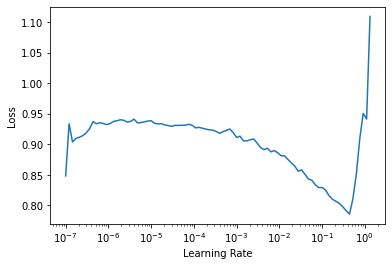

In [31]:
classifier.lr_find()

In [32]:
classifier.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.756185,0.496842,0.825905,00:10


In [33]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.508315,0.290107,0.915042,00:12


In [34]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.333034,0.198486,0.927577,00:18


In [35]:
classifier.unfreeze()
classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.256285,0.171210,0.937326,00:23
1,0.229714,0.164213,0.935933,00:23
2,0.208024,0.181556,0.924791,00:23


In [ ]:
#learn.save(dest/'v1_final')

In [36]:
classifier.show_results()

,text,category,category_
0,"xxbos 1 . xxup aids . 2010 xxmaj jan xxunk - 37 . doi : 10.1097 / xxunk . xxmaj the effect combined antiretroviral therapy overall mortality hiv - infected individuals . xxup hiv - causal xxmaj collaboration , xxmaj ray xxup m , xxmaj logan xxup r , xxmaj sterne xxup ja , hernández - díaz xxup s , xxmaj robins xxup jm , xxmaj sabin xxup c , xxmaj xxunk xxup l , van xxmaj sighem xxup a , de xxmaj wolf xxup f , xxmaj costagliola xxup d , xxmaj xxunk xxup e , xxmaj bucher xxup hc , von xxmaj xxunk xxup v , xxmaj esteve xxup a , xxmaj xxunk xxup j , del xxmaj amo xxup j , xxmaj moreno xxup s , xxmaj justice xxup a , xxmaj goulet xxup j , xxmaj lodi xxup s , xxmaj phillips xxup a , xxmaj",0,0
1,"xxbos 1 . xxmaj biochem xxmaj pharmacol . 2014 xxmaj jul xxunk - 87 . doi : 10.1016 / xxunk . xxmaj epub 2014 xxmaj apr 30 . xxmaj tylvalosin exhibits anti - inflammatory property attenuates acute lung injury different models possibly suppression xxup nf - κb activation . xxmaj zhao xxup z(1 ) , xxmaj tang xxup x(2 ) , xxmaj zhao xxup x(3 ) , xxmaj zhang xxup m(4 ) , xxmaj zhang xxup w(5 ) , xxmaj hou xxup s(6 ) , xxmaj yuan xxup w(7 ) , xxmaj zhang xxup h(8 ) , xxmaj shi xxup xxunk ) , xxmaj jia xxup h(10 ) , xxmaj liang xxup xxunk ) , xxmaj lai xxup xxunk ) , xxmaj gao xxup xxunk ) , xxmaj zhang xxup xxunk ) , xxmaj fu xxup xxunk ) , xxmaj chen xxup xxunk ) . xxmaj author information : (",0,0
2,"xxbos 1 . xxmaj int j xxmaj public xxmaj health . 2018 xxunk xxunk - 108 . doi : 10.1007 / s xxrep 3 0 38 - 017 - 1007 - 0 . xxmaj epub 2017 xxmaj aug 3 . xxmaj burden lower respiratory infections xxmaj eastern xxmaj mediterranean xxmaj region 1990 2015 : findings xxmaj global xxmaj burden xxmaj disease 2015 study . xxup xxunk 2015 xxmaj eastern xxmaj mediterranean xxmaj region xxmaj lower xxmaj respiratory xxmaj infections xxmaj collaborators . xxmaj collaborators : xxunk - xxunk xxup m , xxmaj el xxmaj xxunk xxup c , xxmaj xxunk xxup r , xxmaj xxunk xxup i , xxmaj xxunk xxup a , xxmaj xxunk xxup nj , xxmaj xxunk xxup m , xxmaj xxunk xxup f , xxmaj chew xxup a , xxmaj xxunk xxup kj , xxmaj xxunk xxup d , xxmaj xxunk xxup r , xxmaj xxunk",0,0
3,"xxbos 1 . xxmaj viruses . 2016 xxmaj jun xxunk ) . pii : xxup xxunk . doi : 10.3390 / xxunk . xxmaj identification xxmaj vimentin xxmaj potential xxmaj therapeutic xxmaj target xxup hiv xxmaj infection . fernández - ortega xxup c(1 ) , xxmaj ramírez xxup a(2 ) , xxmaj xxunk xxup d(3 ) , xxmaj xxunk xxup t(4 ) , xxmaj xxunk xxup r(5 ) , xxmaj xxunk xxup m(6 ) , xxmaj xxunk xxup l(7 ) , xxunk - serra xxup l(8 ) , xxmaj duarte xxup c(9 ) , xxmaj xxunk xxup xxunk ) , xxmaj reyes xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj silva xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj ramos xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) . xxmaj author information : ( 1)center xxmaj genetic",0,0
4,"xxbos 1 . xxmaj proc xxmaj natl xxmaj acad xxmaj sci u s xxup a. 2016 xxmaj feb xxunk - 96 . doi : 10.1073 / xxunk . xxmaj epub 2016 xxmaj jan 14 . xxmaj sensing latent xxup ebv infection xxunk transfer 5 ' xxrep 3 p xxup rna . xxmaj xxunk xxup sr(1 ) , van xxmaj xxunk xxup ma(1 ) , xxunk - xxunk xxup d(2 ) , xxmaj berenguer xxup j(3 ) , xxmaj xxunk xxup xxunk ) , xxmaj gibbs xxup s(5 ) , xxmaj xxunk xxup n(6 ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup es(1 ) , xxmaj swaminathan xxup s(8 ) , xxmaj verkuijlen xxup sa(1 ) , xxmaj xxunk xxup gl(1 ) , van xxmaj xxunk xxup xxunk ) , de xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk ) , xxmaj xxunk xxup xxunk )",0,0
5,"xxbos 1 . xxmaj nucleic xxmaj acids xxmaj res . 2016 xxmaj mar xxunk . doi : 10.1093 / nar / xxunk . xxmaj epub 2015 xxmaj nov 17 . xxmaj an ultra - dense library resource rapid deconvolution mutations cause phenotypes xxmaj escherichia coli . xxmaj xxunk xxup rb(1 ) , xxmaj gu xxup f(2 ) , xxmaj lin xxup hy(1 ) , xxmaj xxunk xxup jl(1 ) , xxmaj xxunk xxup mj(3 ) , xxmaj wilson xxup r(3 ) , xxmaj bravo xxmaj n

,input,target,predicted,probability,loss
0,"xxbos 1 . xxmaj virology . 2006 xxmaj feb xxunk - 55 . xxmaj epub 2005 xxmaj oct 25 . xxup hiv-1 xxmaj nef stabilizes xxup ap-1 membranes without inducing xxunk de novo attachment . xxmaj coleman xxup sh(1 ) , xxmaj xxunk xxup d , xxmaj xxunk xxup cm , xxmaj xxunk xxup jc . xxmaj author information : ( 1)department xxmaj medicine , xxmaj university xxmaj california , xxmaj san xxmaj diego , 9500 xxmaj gilman xxmaj dr . , xxmaj la xxmaj jolla , xxup ca 92093 - xxunk , xxup usa . xxup hiv-1 xxmaj nef affects trafficking numerous cellular proteins optimize viral replication evade host defenses . xxmaj the adaptor protein ( ap ) complexes , form part cytoplasmic coat endosomal vesicles , key cellular co - factors xxmaj nef . xxmaj nef binds complexes alters physiologic cycle attachment release membranes . xxmaj specifically ,",0,1,0.9895108342170715,4.557419776916504
1,"xxbos 1 . xxmaj proc xxmaj natl xxmaj acad xxmaj sci u s xxup a. 2012 xxmaj dec xxunk - 6 . doi : 10.1073 / xxunk . xxmaj epub 2012 xxmaj nov 26 . xxmaj structural basis xxmaj marburg virus xxunk immune evasion mechanisms . xxmaj xxunk xxup p(1 ) , xxmaj edwards xxup mr , xxmaj xxunk xxup rs , xxmaj leung xxup dw , xxunk - xxunk xxup ac , xxmaj xxunk xxup dm , xxmaj xxunk xxup z , xxmaj liu xxup g , xxmaj huh xxup j , xxmaj basler xxup cf , xxmaj xxunk xxup gk . xxmaj author information : ( 1)department xxmaj pathology xxmaj immunology , xxmaj washington xxmaj university xxmaj school xxmaj medicine , xxmaj st . xxmaj louis , xxup mo 63110 , xxup usa . xxmaj filoviruses , marburgvirus ( marv ) ebolavirus ( ebov ) , causative agents",0,1,0.9774571061134338,3.792332172393799
2,"xxbos 1 . xxmaj gut . 2005 xxmaj xxunk - 17 . xxmaj epub 2005 xxmaj may 4 . xxup creb / xxup pka sensitive signalling pathways activate maintain expression levels hepatitis b virus pre - s2 / s promoter . xxmaj xxunk xxup f(1 ) , xxmaj xxunk xxup c , xxmaj xxunk xxup s , xxmaj manns xxup mp , xxmaj trautwein xxup c. xxmaj author information : ( 1)department xxmaj gastroenterology , xxmaj hepatology , xxmaj endocrinology , xxmaj hannover xxmaj medical xxmaj school , carl - neuberg - strasse 1 , xxup xxunk xxmaj hannover , xxmaj germany . xxup background xxup and xxup aims : xxup creb ( camp response element binding protein ) transcription factors key regulators homeostatic functions liver , xxup cre binding increased hepatic inflammation . xxmaj during chronic hepatitis b virus ( hbv ) infection , mutations deletions pre - s",0,1,0.9705485105514526,3.5250110626220703
3,"xxbos 1 . j xxmaj virol . 2005 xxmaj xxunk - 51 . xxmaj rab9 gtpase required replication human immunodeficiency virus type 1 , filoviruses , measles virus . xxmaj murray xxup jl(1 ) , xxmaj xxunk xxup m , mcdonald xxup nj , xxmaj xxunk xxup m , xxmaj sheng xxup j , xxmaj xxunk xxup wj , xxmaj zhao xxup l , xxmaj le xxmaj xxunk xxup jm , xxmaj shaw xxup mw , xxmaj luo xxup cc , xxunk - schwartz xxup j , xxmaj sanchez xxup a , xxmaj rubin xxup dh , xxmaj hodge xxup tw . xxmaj author information : ( 1)national xxmaj center xxup hiv , xxup std , xxup tb xxmaj prevention , xxmaj centers xxmaj disease xxmaj control xxmaj prevention , xxmaj atlanta , xxmaj georgia 30 xxrep 3 3 , xxup usa . xxmaj rab proteins effectors facilitate vesicular transport",0,1,0.9685006141662598,3.45778751373291
4,"xxbos 1 . j xxmaj virol . 2012 xxmaj xxunk - 9 . doi : 10.1128 / xxup xxunk - 11 . xxmaj epub 2012 xxmaj may 2 . xxmaj autophagic clearance xxmaj sin xxmaj nombre hantavirus glycoprotein xxmaj gn promotes virus replication cells . xxmaj xxunk xxup xxunk ) , xxmaj cheng xxup e , xxmaj xxunk xxup ss , xxmaj xxunk xxup mj , xxmaj xxunk xxup s , xxmaj haque xxup a , xxmaj mir xxup ma . xxmaj author information : ( 1)department xxmaj microbiology , xxmaj molecular xxmaj genetics xxmaj immunology , xxmaj university xxmaj kansas xxmaj medical xxmaj center , xxmaj kansas xxmaj city , xxup ks , xxup usa . xxmaj han

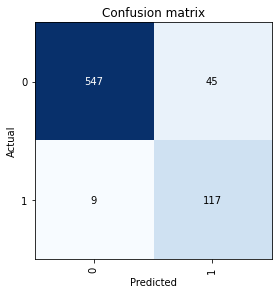

In [37]:
interp = ClassificationInterpretation.from_learner(classifier)
interp.plot_top_losses(9)
interp.plot_confusion_matrix()

## NEXT STEPS: Experiment with different number of epochs with final models to get best accuracy and LR (before overfitting)
# Plot ROC curve and Confusion Matrix for our model
# Load Dataloaders using datablocks method

In [38]:
## Accuracy
preds, y, loss = classifier.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 92.47911071777344 %.


In [39]:
## ROC-AuC Calculation + plots
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9808223401973404


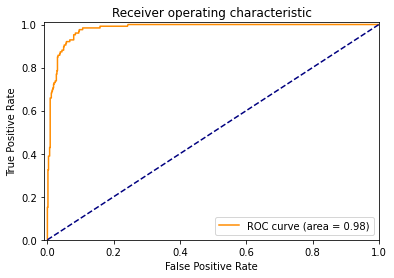

In [40]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [43]:
# saving model
classifier.export("/content/gdrive/My Drive/fastai-v3/models/vip_model")